# Step 2. Specify Possible Sensor Locations

In this step, we first use regular grids across the site. We then filter out all locations that are occupied by equipment groups on the site. We also specify locations along fence line, which can be used to determine optimal fence line sensor placement.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path

In [20]:
# specify dirs
data_dir = './input_data/'
save_dir = './output_data/'

In [21]:
# read in data
df_source_locs = pd.read_csv(data_dir + 'source_locations.csv')  # locations for all potential sources
df_domain = pd.read_csv(data_dir + 'domain.csv') # domain boundaries of the site
df_equip_vertices = pd.read_csv(data_dir + 'equipment_vertices.csv') # vertex locations for all equipment groups

## 2.1 Load in geometric information of the site

In [22]:
# domain bounds
x_min, x_max, y_min, y_max, z_min, z_max, dx, dy, dz = df_domain.iloc[0]

# equipment polygons
polygons = []
for equip_name, group in df_equip_vertices.groupby('EquipName'):
    vertices = []
    for _, row in group.iterrows():
        vertices.append([row['Vertex_x.m'], row['Vertex_y.m']])
    polygons.append(Polygon(vertices, closed=True, color='lightgray'))

## 2.2 Use regular grids for the entire site

In [23]:
# set grids 
nx = int((x_max - x_min) / dx) + 1
ny = int((y_max - y_min) / dx) + 1
nz = int((z_max - z_min) / dz) + 1
xs = np.linspace(x_min, x_max, nx)
ys = np.linspace(y_min, y_max, ny)
zs = np.linspace(z_min, z_max, nz)
X, Y, Z = np.meshgrid(xs, ys, zs)  
grid_xs = X.ravel()
grid_ys = Y.ravel()
grid_zs = Z.ravel()
grid_ids = [f"{x}-{y}-{z}" for y in range(ny) for x in range(nx) for z in range(nz)]  # refer to np.meshgrid for the order
df_grid_locs = pd.DataFrame({'loc_index': range(len(grid_ids)),
                             'grid_id': grid_ids,
                             'x': grid_xs,
                             'y': grid_ys,
                             'z': grid_zs})
df_grid_locs.to_csv(save_dir + 'grid_locations.csv', index=False)

## 2.3 Filter invalid locaitons which are occupied by equipment groups

In [24]:
# set valid sensor locations by filtering out equipment occupied locaitons
def is_point_inside_polygon(test_point, polygon):
    '''
    Check if the given point 'test_point' falls inside the 
    given polygon 'polygon'
    Returns True if 'test_point' is inside 'polygon'.
    '''
    return Path(polygon.get_xy()).contains_point(test_point)


dropped_rows = []
for index, row in df_grid_locs.iterrows(): # loop for each grid point
    loc_index, x, y = row[['loc_index', 'x', 'y']]
    test_point = [x, y]
    if any([is_point_inside_polygon(test_point, polygon) for polygon in polygons]):
        dropped_rows.append(loc_index)
df_valid_sensor_locs = df_grid_locs.drop(dropped_rows)
df_valid_sensor_locs.reset_index(drop=True, inplace=True)
df_valid_sensor_locs.to_csv(save_dir + 'valid_sensor_locations.csv', index=False)

## 2.4 Set possible sensor locations on fence line

In [25]:
# set possible fenceline sensor loations
x_buffer, y_buffer = (2, 2) # [m] the buffers to define fenceline
dropped_rows = []
for index, row in df_grid_locs.iterrows():
    x = int(row['x'])
    y = int(row['y'])
    if (x_min + x_buffer < x < x_max-x_buffer) and (y_min + y_buffer < y < y_max-y_buffer):
        dropped_rows.append(index)
       
df_fenceline_sensor_locs = df_grid_locs.drop(dropped_rows)
df_fenceline_sensor_locs.reset_index(drop=True, inplace=True)
df_fenceline_sensor_locs.to_csv(save_dir + 'fenceline_sensor_locations.csv', index=False)

## 2.5 Visualize possible sensor locations

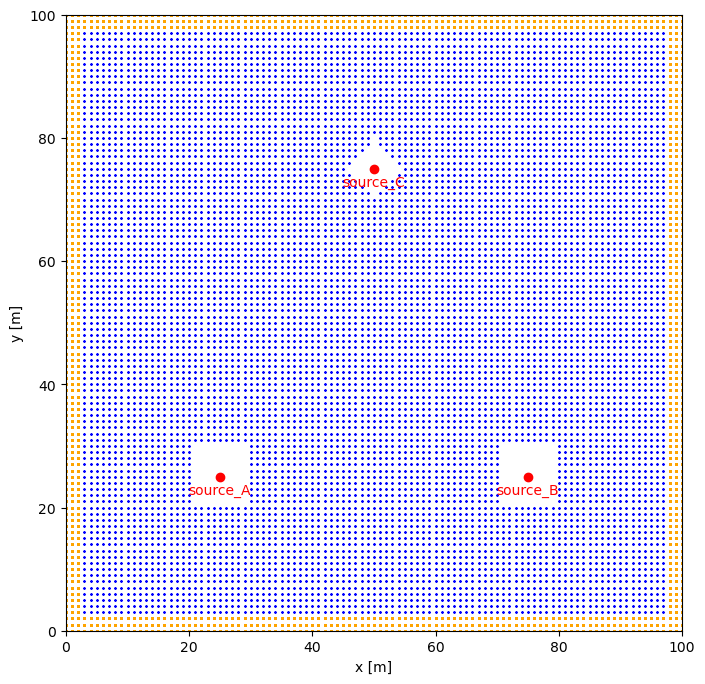

In [26]:
# visualization
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal', adjustable='box')
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

# Plot valid sensor locations
valid_xs = df_valid_sensor_locs['x'].to_numpy()
valid_ys = df_valid_sensor_locs['y'].to_numpy()
ax.scatter(valid_xs, valid_ys, color='blue', s=0.1)

# Plot fenceline sensor locations
fenceline_xs = df_fenceline_sensor_locs['x'].to_numpy()
fenceline_ys = df_fenceline_sensor_locs['y'].to_numpy()
ax.scatter(fenceline_xs, fenceline_ys, color='orange', s=1)

# Plot source locations
for i, row in df_source_locs.iterrows():
    source_name = row['SourceName']
    x, y = row[['x.m', 'y.m']]
    ax.scatter(x, y, color='red')
    ax.text(x, y - 1 , source_name, 
            color='red', va='top', ha='center')    
